## Import

This section includes imports of key libraries for data analysis and statistical modeling:

- **NumPy (`numpy`)**: Supports arrays and matrices with a wide range of mathematical functions.
- **Matplotlib (`matplotlib.pyplot`)**: Enables the creation of 2D and 3D graphics.
- **Pandas (`pandas`)**: Provides robust data structures and tools for efficient data manipulation.
- **MetaTrader 5 (`MetaTrader5`)**: Offers integration with MetaTrader 5 for financial data analysis.
- **DateTime (`datetime`)**: Essential for manipulating dates and times in time series analysis.
- **Scikit-learn (`StandardScaler`)**: Important for feature normalization in machine learning.
- **Statsmodels (`seasonal_decompose`)**: Useful for statistical model estimation and data exploration.
- **Seaborn (`seaborn`)**: Facilitates the creation of attractive statistical graphics.
- **Statsmodels API (`smi`)**: Provides an interface for statistical tests and model integration with data.
- **Scipy (`norm`)**: Applied in various mathematical, scientific, and engineering tasks, particularly with the normal distribution.

These libraries form the backbone of our data manipulation, analysis, and visualization toolkit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MetaTrader5 as mt5
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import statsmodels.api as smi
from scipy.stats import norm

## Financial Data Preparation with `Process_Data`

The `Process_Data` function is streamlined to efficiently fetch and preprocess financial data:

1. **Initialization**: Begins by establishing a connection with MetaTrader 5, aborting with `None` returns upon failure.
2. **Retrieval**: Extracts historical data for specified symbols and timeframes, converting it to Pandas DataFrames.
3. **Cleaning**: Removes extraneous columns and standardizes remaining column names, with timestamp conversion for indexing.
4. **Concatenation**: Merges individual symbol DataFrames into a unified DataFrame, distinguishing symbols via a multi-level index.
5. **Standardization**: Applies normalization to numerical columns, setting the stage for enhanced analytical consistency and model compatibility.

The outcome is a pair of DataFrames: `df` for concatenated raw data and `df_standardized` for normalized data, ready for advanced analysis or modeling.


In [2]:
def Process_Data(start_date, end_date, symbols, timeframe):
    # Initialize MetaTrader 5 connection
    if not mt5.initialize():
        print("Initialize() failed, error code =", mt5.last_error())
        return None, None

    # Fetch and structure data for each symbol
    symbols_data = {
        symbol: pd.DataFrame(rates)
        for symbol in symbols
        if (rates := mt5.copy_rates_range(symbol, timeframe, start_date, end_date))
        is not None
    }
    for symbol, df in symbols_data.items():
        # Clean and rename data columns
        df.drop(columns=["spread", "real_volume"], inplace=True)
        df.rename(
            columns={
                "time": "date",
                "tick_volume": "Volume",
                "open": "Open",
                "high": "High",
                "low": "Low",
                "close": "Close",
            },
            inplace=True,
        )
        # Convert 'time' to readable 'date'
        df["date"] = pd.to_datetime(df["date"], unit="s")
        df.set_index("date", inplace=True)
        # Ensure data types are consistent
        df[["Open", "High", "Low", "Close", "Volume"]] = df[
            ["Open", "High", "Low", "Close", "Volume"]
        ].astype("float64")

    # Check for empty data
    if not symbols_data:
        print("No data available for the specified symbols and date range.")
        return None, None

    # Concatenate dataframes and standardize
    df = pd.concat(
        symbols_data.values(), keys=symbols_data.keys(), names=["Symbol", "date"]
    ).reset_index(level="Symbol")
    df_standardized = df.copy()

    # Apply standardization
    for symbol in symbols_data:
        scaler = StandardScaler()
        df_standardized.loc[
            df_standardized["Symbol"] == symbol,
            ["Open", "High", "Low", "Close", "Volume"],
        ] = scaler.fit_transform(
            df_standardized.loc[
                df_standardized["Symbol"] == symbol,
                ["Open", "High", "Low", "Close", "Volume"],
            ]
        )
    return df, df_standardized


# Function usage setup
inp_start_date = datetime(2010, 1, 1)
inp_end_date = datetime(2023, 12, 31)
timeframe = mt5.TIMEFRAME_D1  # Timeframe selection
# Symbol list definition
symbols = [
    "EURUSD",
    "GBPCAD",
    "EURGBP",
]

# Execute data processing
df, df_standardized = Process_Data(inp_start_date, inp_end_date, symbols, timeframe)

# Confirm successful data processing
if df is not None and df_standardized is not None:
    print("Data processed successfully.")

Data processed successfully.


## Financial Data Overview and Statistics

This cell succinctly summarizes the financial dataset's structure and key statistics:

1. **Dataset Preview**: Utilizes `.head()` and `.tail()` to display the dataset's start and end, showcasing data format and scale.
2. **Framework Summary**: `.info()` provides a concise framework outline, including column specifics and data types.
3. **Statistical Insight**: `.describe()` delivers core statistical metrics for numeric columns, highlighting distribution traits.
4. **Type Clarification**: `df_standardized.dtypes` identifies column data types, elucidating dataset composition.
5. **Numerical Analysis Prep**: Isolates numeric columns for focused analysis, streamlining subsequent statistical evaluations.
6. **Dataset Scale**: Reveals the numeric subset's dimensions, offering perspective on data volume.
7. **Trend Indicators**: Mean and median calculations expose central tendencies, aiding in bias and trend assessments.

This efficient analysis establishes a foundational understanding of the dataset, paving the way for in-depth exploration and modeling.


In [3]:
df_standardized.head()

,Symbol,Open,High,Low,Close,Volume
date,,,,,,
2010-01-04,EURUSD,2.055330,2.116649,2.050296,2.131925,-0.865219
2010-01-05,EURUSD,2.129529,2.141665,2.129415,2.089270,-0.837030
2010-01-06,EURUSD,2.087967,2.098781,2.073379,2.122027,-0.866890
2010-01-07,EURUSD,2.120254,2.109066,2.087741,2.038206,-0.894028
2010-01-08,EURUSD,2.036080,2.092244,2.056023,2.129647,-1.129682


In [4]:
df_standardized.tail()

,Symbol,Open,High,Low,Close,Volume
date,,,,,,
2023-12-22,EURGBP,0.456909,0.394794,0.438473,0.452333,-0.653600
2023-12-26,EURGBP,0.428818,0.411272,0.490641,0.462624,-1.200123
2023-12-27,EURGBP,0.456481,0.438236,0.481410,0.462409,-1.070033
2023-12-28,EURGBP,0.460126,0.471834,0.509533,0.488351,-0.850514
2023-12-29,EURGBP,0.480712,0.442516,0.490641,0.444829,-0.743152


In [5]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10893 entries, 2010-01-04 to 2023-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Symbol  10893 non-null  object 
 1   Open    10893 non-null  float64
 2   High    10893 non-null  float64
 3   Low     10893 non-null  float64
 4   Close   10893 non-null  float64
 5   Volume  10893 non-null  float64
dtypes: float64(5), object(1)
memory usage: 595.7+ KB


In [6]:
df_standardized.describe()

,Open,High,Low,Close,Volume
count,1.089300e+04,1.089300e+04,1.089300e+04,1.089300e+04,1.089300e+04
mean,3.600657e-16,-1.722053e-15,-2.713539e-16,8.036249e-16,-5.218344e-18
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-3.262531e+00,-3.248310e+00,-3.212002e+00,-3.268236e+00,-1.979818e+00
25%,-7.281265e-01,-7.326717e-01,-7.306682e-01,-7.284962e-01,-7.578010e-01
50%,1.237778e-02,7.265845e-03,1.339257e-02,1.250277e-02,-2.717949e-01
75%,6.580851e-01,6.614495e-01,6.553035e-01,6.560058e-01,6.118902e-01
max,3.436349e+00,3.371220e+00,3.358776e+00,3.426503e+00,5.784472e+00


In [7]:
print("--------Data type of each column")
print(df_standardized.dtypes)

--------Data type of each column
Symbol     object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [8]:
numeric_cols = df_standardized.select_dtypes(include=np.number)

print("--------Number of rows and columns in the numeric DataFrame")
print(numeric_cols.shape)

print("--------Average of each numerical column")
print(numeric_cols.mean())

print("--------Median of each numerical column")
print(numeric_cols.median())

print("--------Asymmetry (Skewness) of each numerical column")
print(numeric_cols.skew())

--------Number of rows and columns in the numeric DataFrame
(10893, 5)
--------Average of each numerical column
Open      3.600657e-16
High     -1.722053e-15
Low      -2.713539e-16
Close     8.036249e-16
Volume   -5.218344e-18
dtype: float64
--------Median of each numerical column
Open      0.012378
High      0.007266
Low       0.013393
Close     0.012503
Volume   -0.271795
dtype: float64
--------Asymmetry (Skewness) of each numerical column
Open      0.078657
High      0.098397
Low       0.059401
Close     0.079095
Volume    1.045141
dtype: float64


## Financial Symbol Price

This cell crafts a clear visualization of price movements over time for various financial symbols:

1. **Initialization**: Configures a plot with optimized dimensions for clarity and comparative analysis.
2. **Data Segmentation**: Organizes data by symbol, with each line uniquely representing a financial instrument.
3. **Visualization**: Employs line graphs with customized settings to enhance readability and visual appeal.
4. **Annotations**: Annotates the plot with a descriptive title, axis labels, and a legend for easy symbol identification.
5. **Display**: Renders the visualization with `plt.show()`, showcasing temporal price trends across symbols.

This streamlined approach provides valuable insights into market dynamics and symbol correlations.


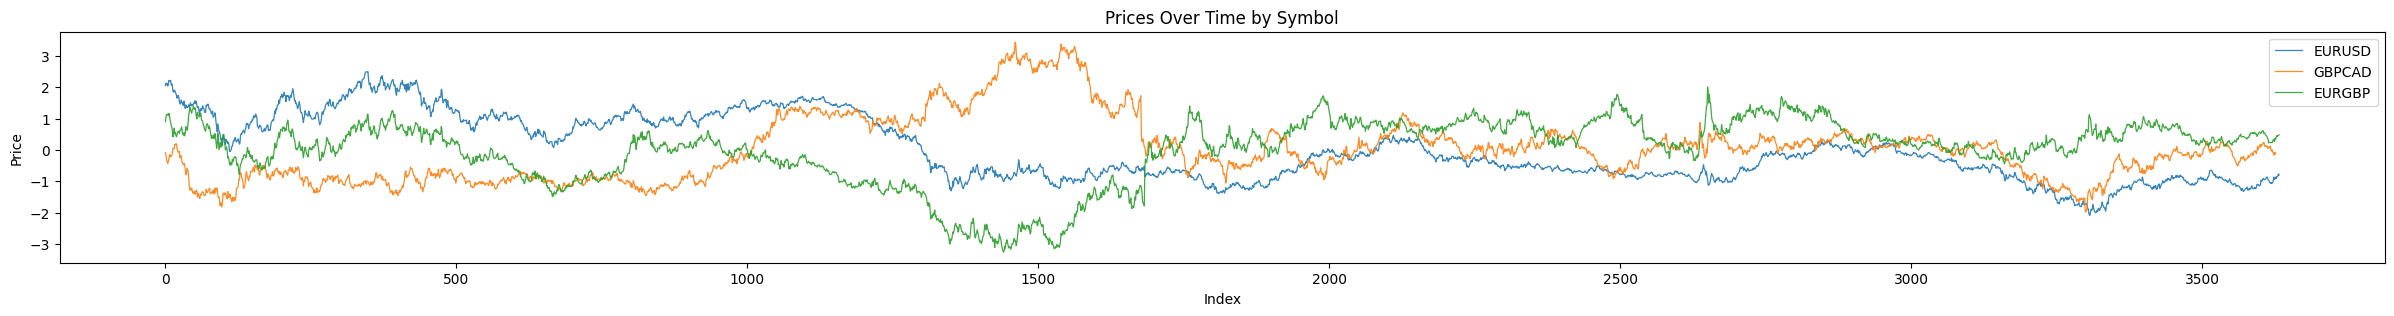

In [9]:
# Initialize a large figure for plotting price
plt.figure(figsize=(30, 3))

# Iterate through each symbol and plot its price trend
for symbol in symbols:
    df_filtered = df_standardized[df_standardized["Symbol"] == symbol]
    rate_value = df_filtered["Open"].values
    plt.plot(rate_value, label=f"{symbol}", linewidth=0.9, alpha=0.9)  # Plot each symbol's prices

# Set plot titles and labels
plt.title("Prices Over Time by Symbol")
plt.xlabel("Index")  # Index refers to the time or sequence order
plt.ylabel("Price")
plt.legend()  # Display legend to identify symbols

# Display the plot
plt.show()


## Metric Distribution Visualization

This cell provides a concise visualization of financial metric distributions.

1. **Data Prep**: Applies a filter to `df_standardized`.
2. **Framework**: Sets up the plotting canvas for multiple metrics.
3. **Detailing**: Each metric is visualized in a separate subplot for distinct analysis, with data segmented by 'Symbol'.
4. **Visualization**: Employs histograms with standardized bin count and transparency for comparative insights.
5. **Annotation**: Augments subplots with clear titles and legends for identification.
6. **Finalization**: Optimizes subplot layout and presents the comprehensive visualization.

This approach efficiently delineates the distribution characteristics of key financial metrics, facilitating nuanced analysis.


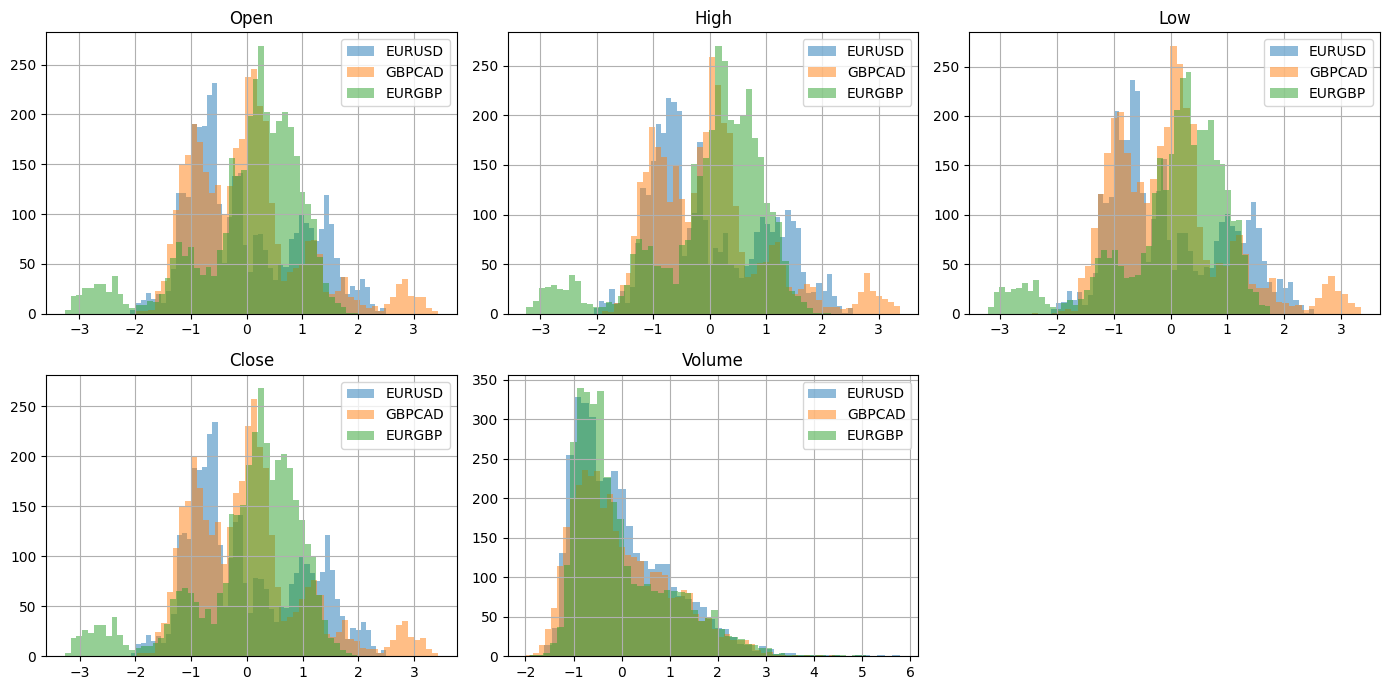

In [10]:
# Filter data starting from a specific date and ensure 'date' is the index
df_plot = df_standardized[
    df_standardized.index.get_level_values("date") >= "2000-01-01"
]

# Set up the figure for subplots
plt.figure(figsize=(14, 7))

# Loop through columns to create subplots, ensuring column names match those in df_standardized
for i, column in enumerate(["Open", "High", "Low", "Close", "Volume"]):
    plt.subplot(2, 3, i + 1)  # Arrange subplots in a 2x3 grid
    # Filter by column and group by 'Symbol' to prevent index overlap issues
    for symbol in df_plot["Symbol"].unique():
        df_plot.loc[df_plot["Symbol"] == symbol, column].hist(
            bins=50, alpha=0.5, label=symbol  # Histogram for each symbol's column data
        )
    plt.title(column)  # Title each subplot with the column name
    plt.legend()  # Include legend to identify symbols

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

## Decomposed Time Series Analysis

This cell concisely decomposes each symbol's price series within `df_standardized`, elucidating core components:

1. **Initialization**: Sets up a multi-part figure to host the decomposition elements.
2. **Iteration**: Tackles each symbol's series, isolating the price data.
3. **Analysis**: Deploys `seasonal_decompose` to dissect the series into observed, trend, seasonal, and residual facets.
4. **Display**:
    - **Observed**: Plots the raw series, tagged as "Observed".
    - **Trend**: Visualizes long-term movements, smoothing over volatility.
    - **Seasonality**: Identifies and illustrates cyclical patterns.
    - **Residuals**: Exposes the remaining data noise post-decomposition.
5. **Refinement**: Enhances clarity with legends and transparency settings.
6. **Presentation**: Optimizes layout and unveils the aggregate figure.

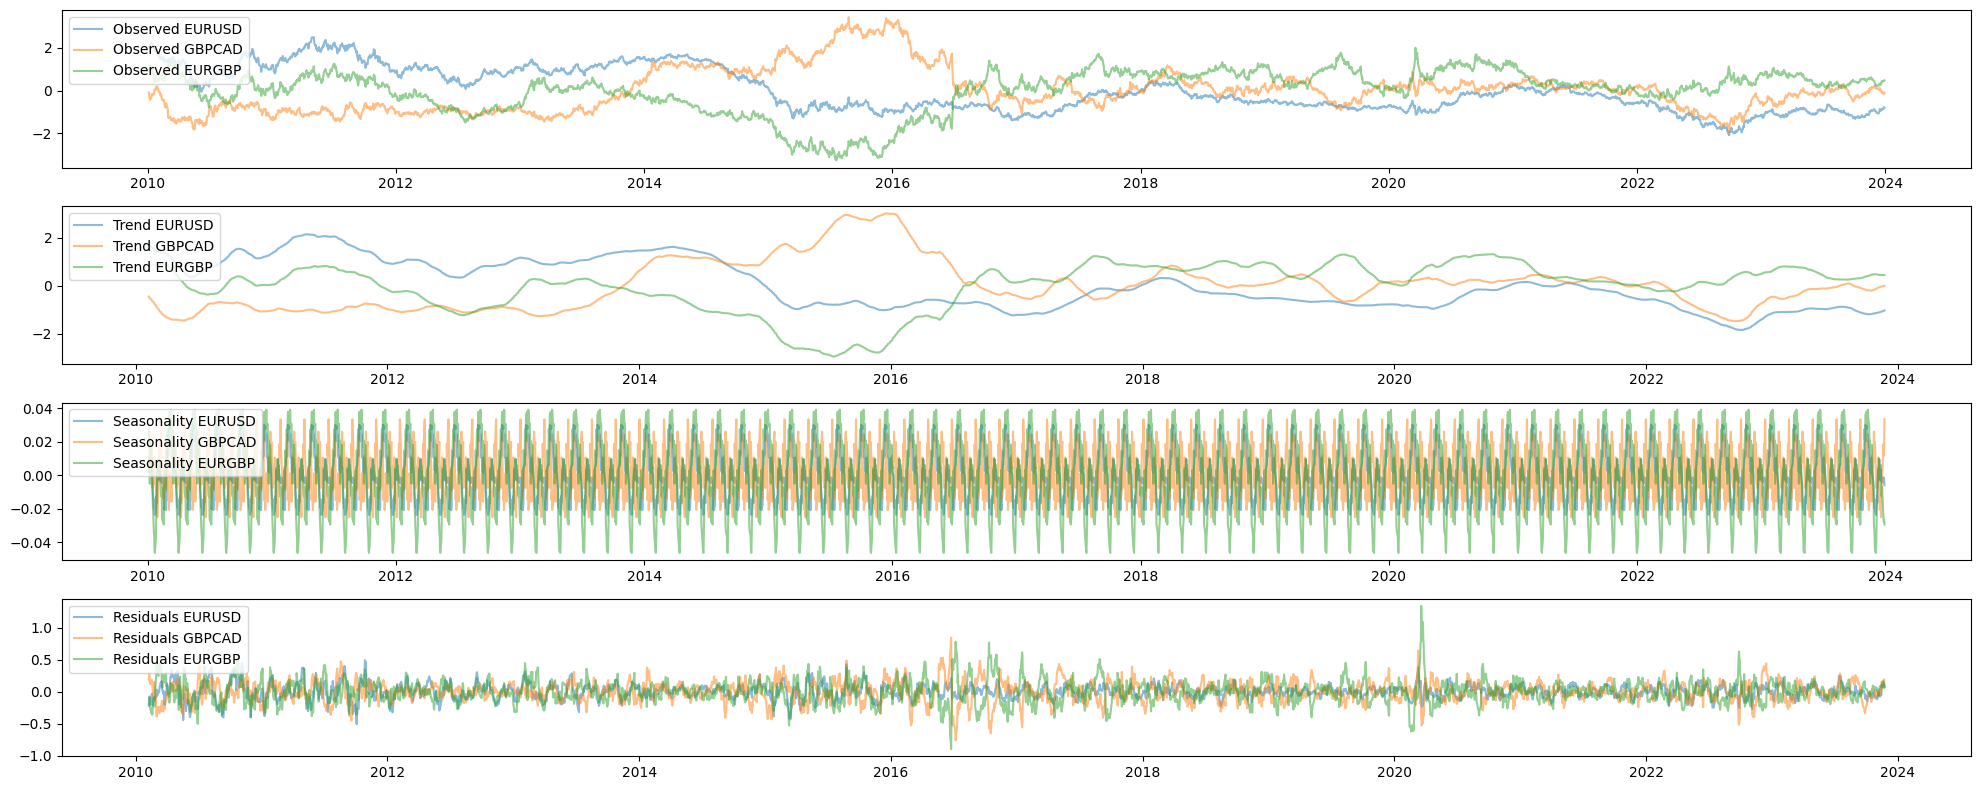

In [11]:
plt.figure(figsize=(20, 8))

# Iterate over each unique symbol in the DataFrame
for symbol in df_standardized["Symbol"].unique():
    # Select the time series for the current symbol
    series = df_standardized[df_standardized["Symbol"] == symbol]["Open"].dropna()

    # Perform decomposition for the current symbol
    decomposition = seasonal_decompose(series, model="additive", period=50)

    # Plot the observed data
    plt.subplot(411)
    plt.plot(
        decomposition.observed.index,
        decomposition.observed,
        label=f"Observed {symbol}",
        alpha=0.5,
    )
    plt.legend(loc="upper left")

    # Plot the trend component
    plt.subplot(412)
    plt.plot(
        decomposition.trend.index,
        decomposition.trend,
        label=f"Trend {symbol}",
        alpha=0.5,
    )
    plt.legend(loc="upper left")

    # Plot the seasonality component
    plt.subplot(413)
    plt.plot(
        decomposition.seasonal.index,
        decomposition.seasonal,
        label=f"Seasonality {symbol}",
        alpha=0.5,
    )
    plt.legend(loc="upper left")

    # Plot the residuals
    plt.subplot(414)
    plt.plot(
        decomposition.resid.index,
        decomposition.resid,
        label=f"Residuals {symbol}",
        alpha=0.5,
    )
    plt.legend(loc="upper left")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the decomposition plots

## Numerical Distribution Visualization

This cell harnesses seaborn to depict the distribution of `df_standardized`'s numerical columns through histograms and KDE:

1. **Seaborn Theme**: Applies a white grid style for enhanced plot readability.
2. **Grid Setup**: Calculates subplot grid dimensions to fit all numerical columns.
3. **Plotting Canvas**: Initializes a suitably sized figure with subplot grid and spacing.
4. **Symbol Colors**: Designates distinct colors per symbol to aid differentiation.
5. **Distribution Plots**: Each numerical column features symbol-specific histograms with KDE overlay, using semi-transparency for clarity in overlap areas.
6. **Annotations**: Subplots are clearly titled by column names, with legends for symbol identification.
7. **Layout Optimization**: Conceals any superfluous subplot axes for a polished presentation.

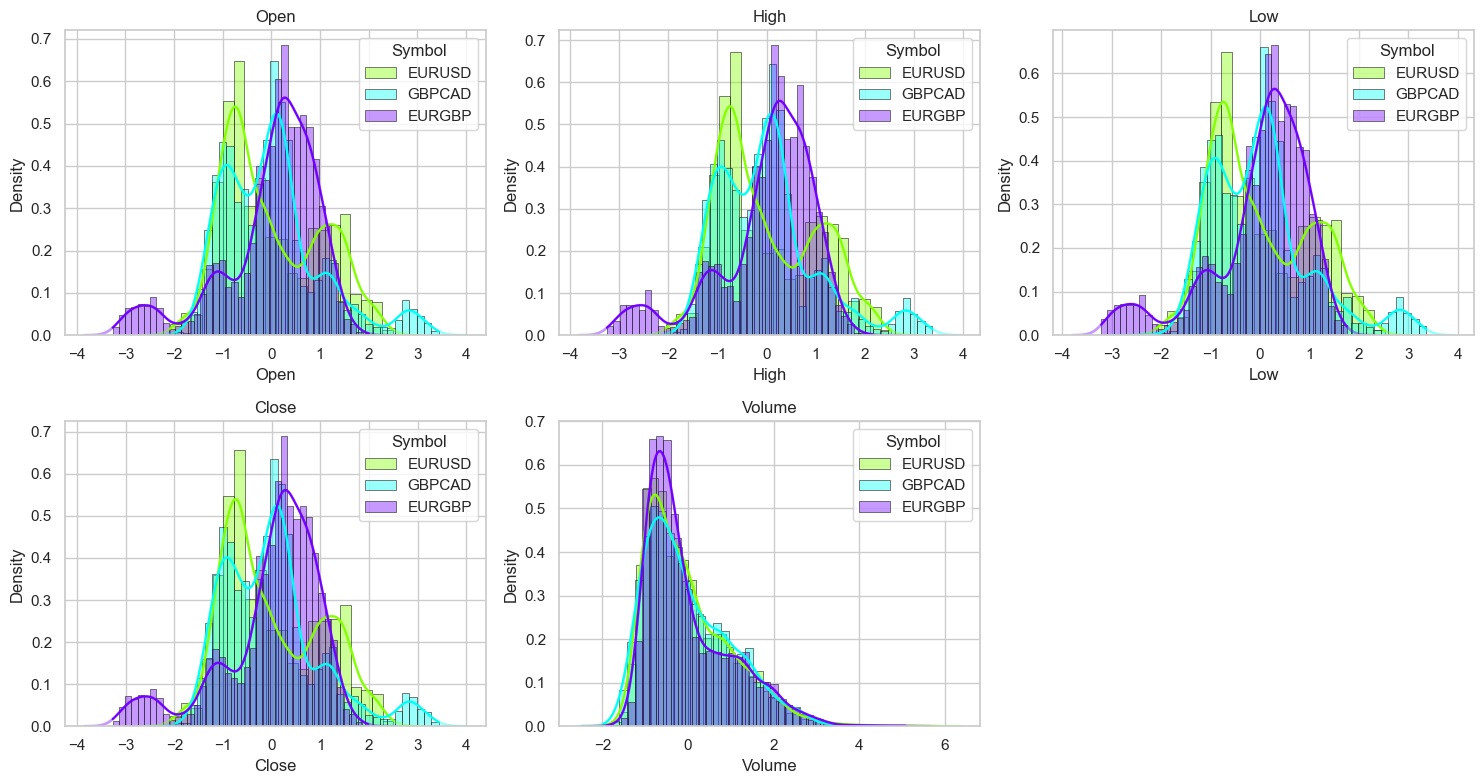

In [12]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Define the number of columns per row for the subplots
columns_per_row = 3

# Count the number of numerical columns
num_columns = len(df_standardized.select_dtypes(include=np.number).columns)

# Calculate the required number of rows to fit all subplots
num_rows = (num_columns + columns_per_row - 1) // columns_per_row  # Round up

# Create a figure and axes array
fig, ax = plt.subplots(num_rows, columns_per_row, figsize=(15, num_rows * 4))
plt.subplots_adjust(wspace=0.3, hspace=0.6)  # Adjust space between subplots

# Define a color palette for symbols
palette = sns.color_palette("hsv", len(df_standardized["Symbol"].unique()))
symbol_colors = {
    symbol: color for symbol, color in zip(df_standardized["Symbol"].unique(), palette)
}

# Iterate over numerical columns to create histograms and KDE for each symbol
for i, column in enumerate(df_standardized.select_dtypes(include=np.number).columns):
    current_row = i // columns_per_row
    current_column = i % columns_per_row
    ax_current = ax[current_row, current_column]

    for symbol in df_standardized["Symbol"].unique():
        symbol_data = df_standardized[df_standardized["Symbol"] == symbol][
            column
        ].dropna()
        color = symbol_colors[symbol]

        # Plot histogram with KDE for each symbol with light opacity
        sns.histplot(
            symbol_data,
            ax=ax_current,
            kde=True,
            stat="density",
            edgecolor="k",
            linewidth=0.4,
            alpha=0.4,
            color=color,
            label=symbol,
        )

        # Adjust KDE density for each symbol with light opacity
        sns.kdeplot(symbol_data, ax=ax_current, linewidth=2, alpha=0.4, color=color)

    # Set subplot title
    ax_current.set_title(column, fontsize=12)

    # Add legend
    ax_current.legend(title="Symbol")

# Hide empty subplots in the last row if necessary
if num_columns % columns_per_row:
    for j in range(num_columns % columns_per_row, columns_per_row):
        fig.delaxes(ax[num_rows - 1, j])

plt.tight_layout()
plt.show()

## Skewness and Mean Insights

This cell succinctly evaluates the skewness and mean of the dataset's numerical columns:

1. **Skewness Chart**: Depicts each column's skewness via a bar chart, elucidating the asymmetry in data distribution. Enhanced with a clear title, axis labels, and rotated x-axis labels for legibility.
2. **Mean Chart**: Showcases the mean values through a bar chart, highlighting the central tendency across columns. Includes a descriptive title and axis labels, with x-axis labels rotated for readability.

The dual-chart setup facilitates an intuitive understanding of distribution shape and central values, presented in an optimized layout for ease of analysis.


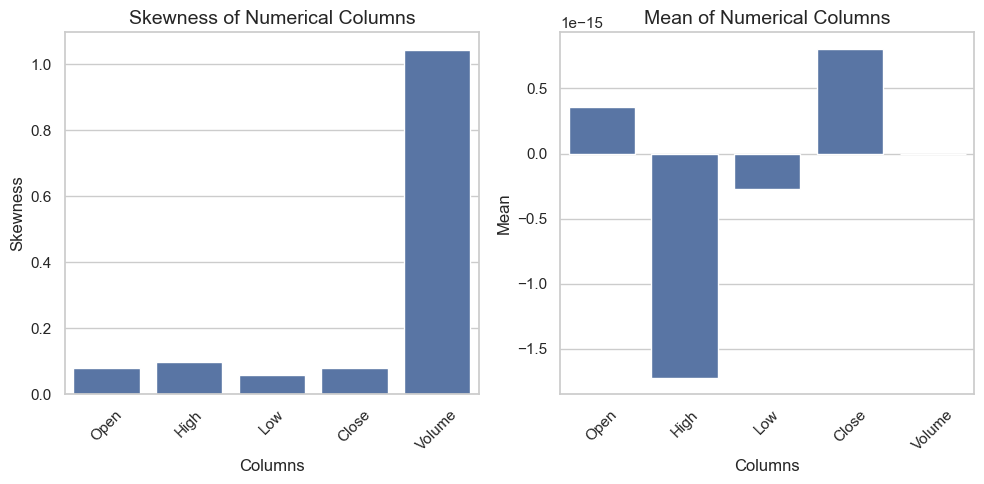

In [13]:
# Calculate skewness and mean values
skewness_values = numeric_cols.skew()
mean_values = numeric_cols.mean()

# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjust size for better visualization

# Bar plot for skewness
sns.barplot(x=skewness_values.index, y=skewness_values.values, ax=ax[0])
ax[0].set_title("Skewness of Numerical Columns", fontsize=14)  # More descriptive title
ax[0].set_xlabel("Columns", fontsize=12)  # Descriptive label for the X axis
ax[0].set_ylabel("Skewness", fontsize=12)  # Descriptive label for the Y axis
ax[0].tick_params(axis="x", rotation=45)  # Rotate labels for better readability

# Bar plot for mean
sns.barplot(x=mean_values.index, y=mean_values.values, ax=ax[1])
ax[1].set_title("Mean of Numerical Columns", fontsize=14)  # More descriptive title
ax[1].set_xlabel("Columns", fontsize=12)  # Descriptive label for the X axis
ax[1].set_ylabel("Mean", fontsize=12)  # Descriptive label for the Y axis
ax[1].tick_params(axis="x", rotation=45)  # Rotate labels for better readability

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding.
plt.show()

## Numerical Column Boxplot Overview

This cell crafts boxplots for `df_standardized`'s numerical columns, illustrating key distribution metrics:

1. **Grid Setup**: Configures subplot grid based on numerical column count, ensuring a coherent layout.
2. **Figure Preparation**: Constructs a figure tailored to the subplot arrangement, optimizing space and legibility.
3. **Boxplot Creation**: Iterates over columns to generate individual boxplots, each clearly labeled by column name.
4. **Layout Adjustment**: Conceals unused subplot areas in the final row for a neat presentation.
5. **Visualization**: Implements `plt.tight_layout()` for layout refinement and displays the aggregated boxplot figure.

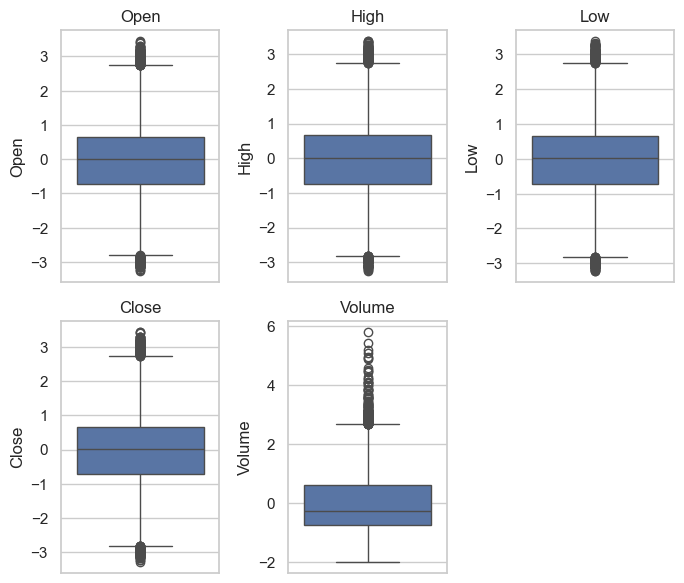

In [14]:
# Set the number of columns per row for subplots
columns_per_row = 3

# Count the number of numerical columns in df_standardized
num_columns = len(df_standardized.select_dtypes(include=np.number).columns)

# Calculate the required number of rows to fit all plots
num_rows = (num_columns + columns_per_row - 1) // columns_per_row  # Ensure rounding up

# Create a figure and axes array
fig, ax = plt.subplots(num_rows, columns_per_row, figsize=(7, num_rows * 3))
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust space between subplots

# Iterate over numerical columns to create boxplots
for i, column in enumerate(df_standardized.select_dtypes(include=np.number).columns):
    current_row = i // columns_per_row
    current_column = i % columns_per_row
    sns.boxplot(
        y=df_standardized[column], ax=ax[current_row, current_column]
    )  # Create boxplot for each column
    ax[current_row, current_column].set_title(
        column
    )  # Title each subplot with the column name

# Hide empty subplots in the last row if any
if num_columns % columns_per_row:
    for j in range(num_columns % columns_per_row, columns_per_row):
        fig.delaxes(ax[num_rows - 1, j])  # Remove unused axes

plt.tight_layout()  # Optimize layout
plt.show()  # Display the figure with all boxplots

## QQ Plot Analysis of Numerical Data

This cell generates QQ plots for `df_standardized`'s numerical columns to compare data distributions against a normal distribution:

1. **Theme Selection**: Sets a "whitegrid" seaborn theme for clear visual presentation.
2. **Layout Determination**: Configures the plot grid, aligning plots in rows based on numerical column quantity.
3. **Plot Infrastructure**: Establishes a figure with subplots tailored to the data's dimensions, optimizing spacing.
4. **Plot Creation**: For each column, constructs a QQ plot using `smi.qqplot`, overlaying data distribution with a standard normal reference, and titles each plot by column name.
5. **Unused Axes Cleanup**: Hides surplus subplot axes to maintain a sleek layout.
6. **Rendering**: Enhances subplot arrangement with `plt.tight_layout()` and presents the plots.

This approach provides a succinct visual assessment of distribution normality, highlighting potential deviations.


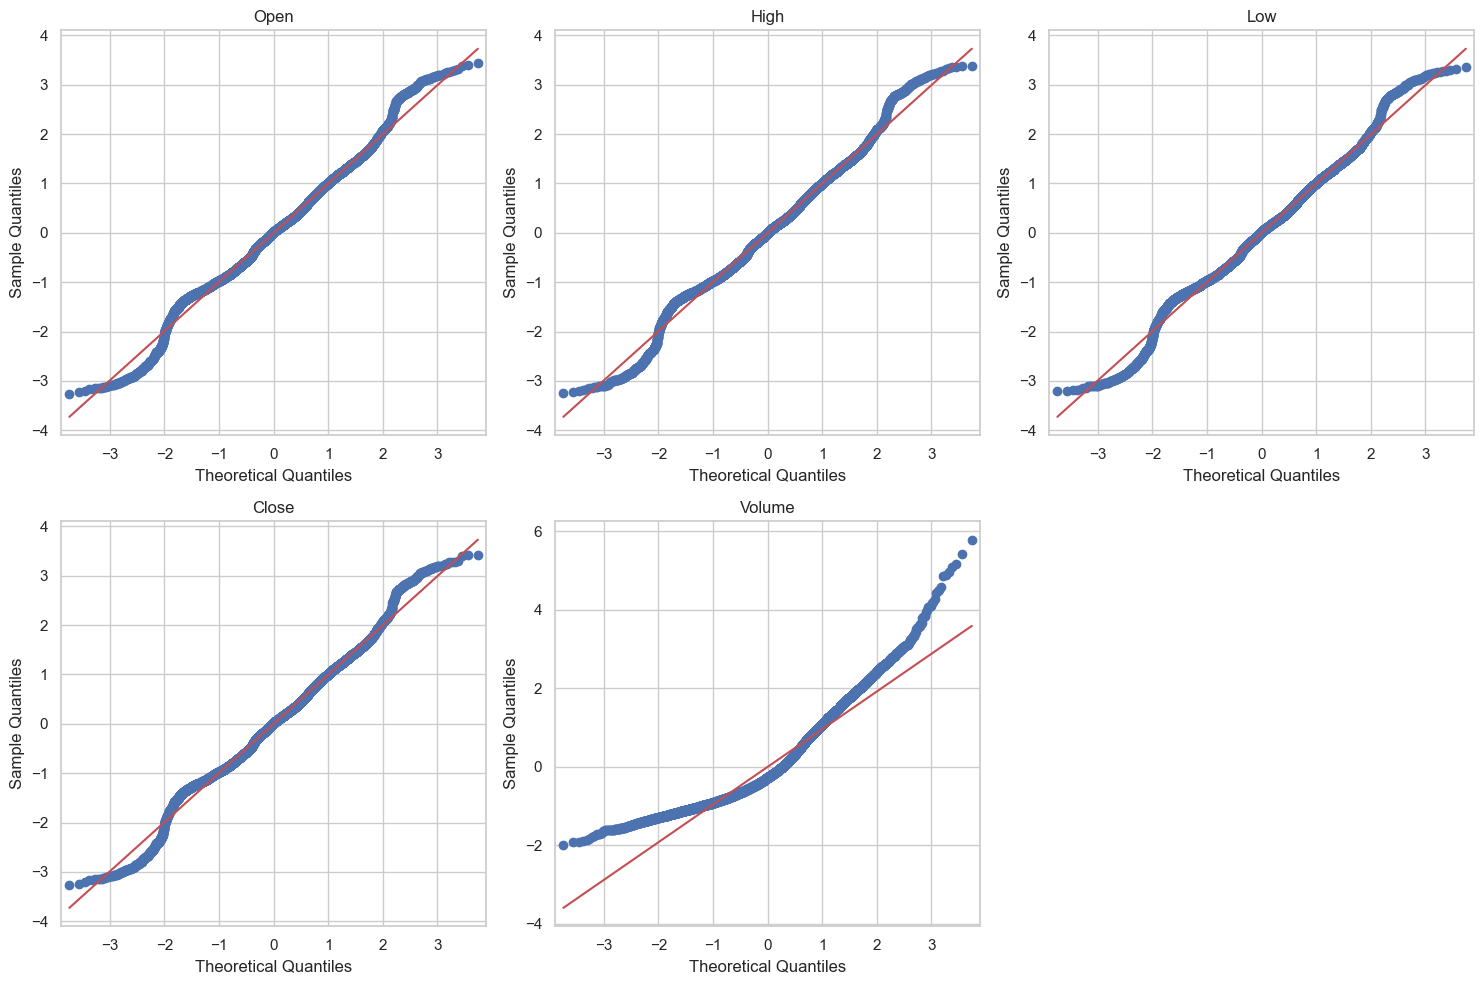

In [15]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Define the number of columns per row for subplots
columns_per_row = 3

# Count the number of numerical columns
num_columns = len(df_standardized.select_dtypes(include=np.number).columns)

# Calculate the required number of rows to fit all plots
num_rows = (num_columns + columns_per_row - 1) // columns_per_row  # Round up

# Create a figure and axes array
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, num_rows * 5))
plt.subplots_adjust(wspace=0.3, hspace=0.6)  # Adjust space between subplots

# Flatten the axes array for easier iteration
ax_flat = axes.flatten()

# Iterate over numerical columns and create QQ plots
for i, column in enumerate(df_standardized.select_dtypes(include=np.number).columns):
    # Generate QQ plot and adjust the axis afterward
    qq_plot = smi.qqplot(df_standardized[column], line="r", ax=ax_flat[i])
    ax_flat[i].set_title(column, fontsize=12)  # Title each subplot with the column name

# Hide empty subplots in the last row if necessary
if num_columns % columns_per_row:
    for j in range(num_columns % columns_per_row, columns_per_row):
        fig.delaxes(
            ax_flat[num_rows * columns_per_row - columns_per_row + j]
        )  # Remove unused axes

plt.tight_layout()  # Optimize layout
plt.show()  # Display the QQ plots

## Pair Plot Overview

This cell leverages `sns.pairplot` for a detailed exploration of `df_standardized`, elucidating inter-variable dynamics:

1. **Style Application**: Adopts "whitegrid" for aesthetic coherence.
2. **Plot Configuration**: Tailors the pair plot with:
    - `corner=True` for lower triangle visualization, enhancing focus.
    - `markers="."` for precise data point depiction.
    - `diag_kind="kde"` for smooth univariate distribution representation on diagonals.
    - Custom `height` and `aspect` settings for plot dimension control.
3. **Titling**: Annotates with "Pair Plot of df_standardized" for context.
4. **Optimization**: Implements `plt.tight_layout()` for spatial efficiency.
5. **Execution**: Exhibits the visualization, revealing nuanced data interrelations.

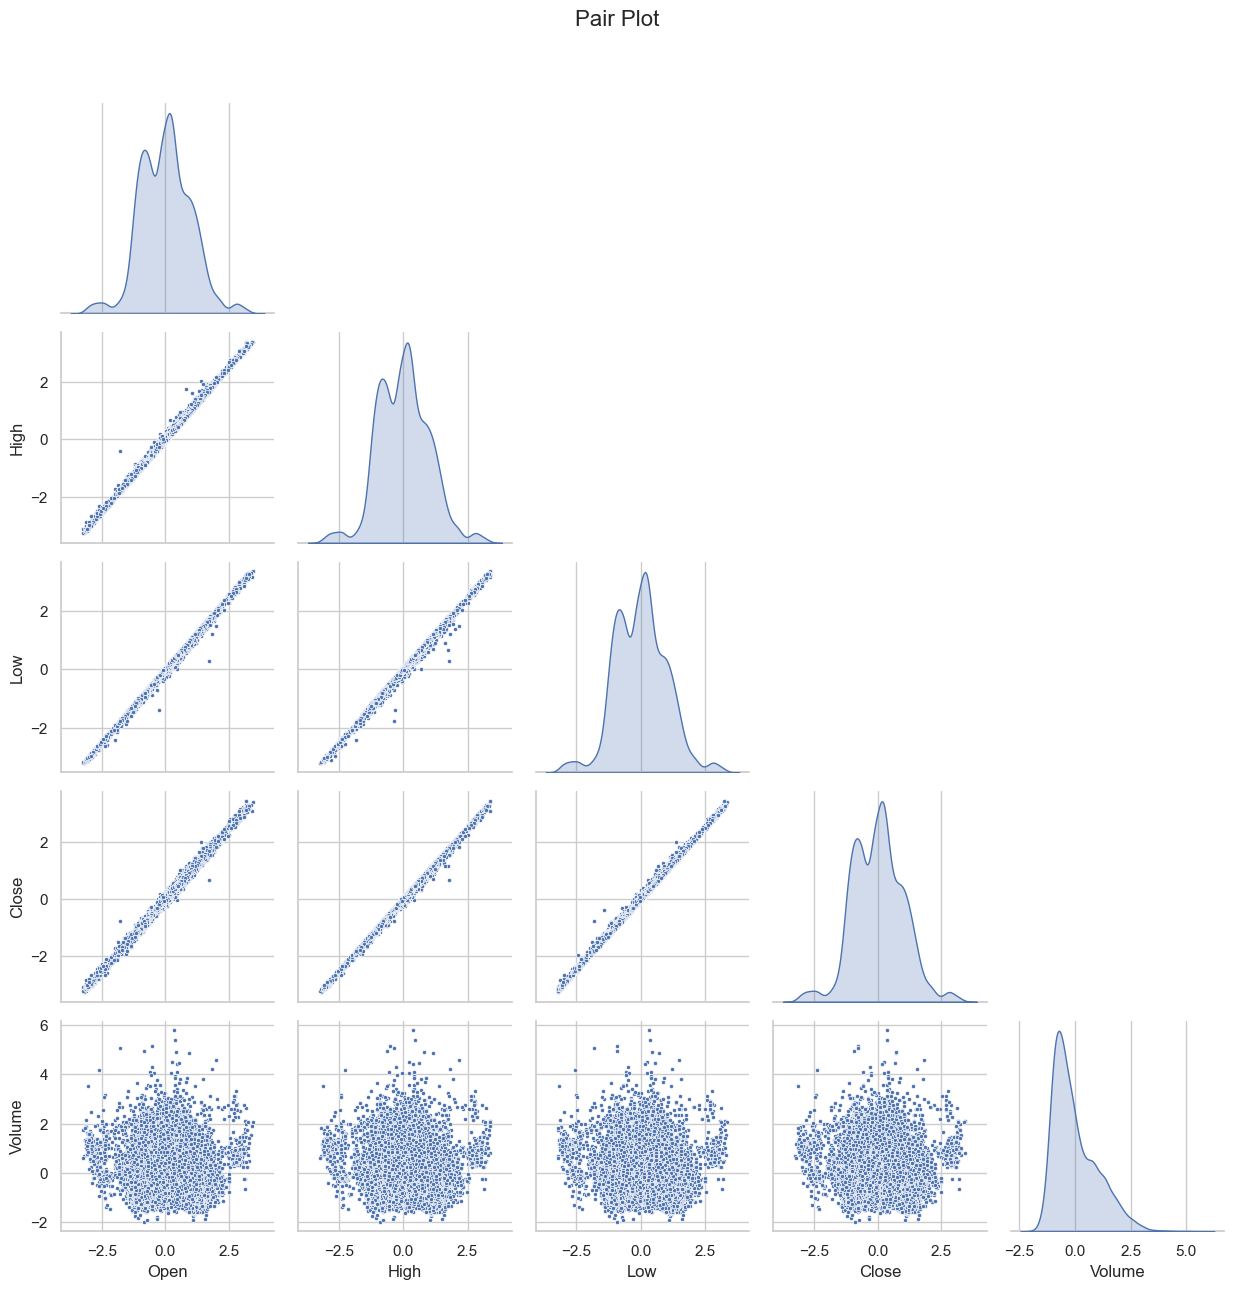

In [16]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create the pair plot
# You can adjust 'height' and 'aspect' to change the size and aspect ratio of individual plots
pair_plot = sns.pairplot(
    df_standardized, corner=True, markers=".", diag_kind="kde", height=2.5, aspect=1
)

# Adjust the main title
pair_plot.figure.suptitle("Pair Plot", y=1.03, fontsize=16)

# Improve readability
plt.tight_layout()

# Show the pair plot
plt.show()

## Price Distribution Analysis

This cell presents a multi-layered analysis of `df_standardized`'s "Open" price data, integrating histogram, KDE, and normal distribution:

1. **Setup**: Adopts "whitegrid" style and initializes a figure for the plot.
2. **Data Metrics**: Derives mean and standard deviation from "Open" prices for distribution analysis.
3. **Normal Curve Fit**: Plots a normal distribution curve based on derived metrics, offering a standard for comparison.
4. **Histogram & KDE**: Background histogram and KDE provide empirical distribution views, juxtaposed against the normal curve.
5. **Styling**: Distinctly marks each plot element for clarity, with an overarching title and a legend for identification.
6. **Execution**: Displays the composite visualization, offering insights into the empirical distribution versus the normal benchmark.

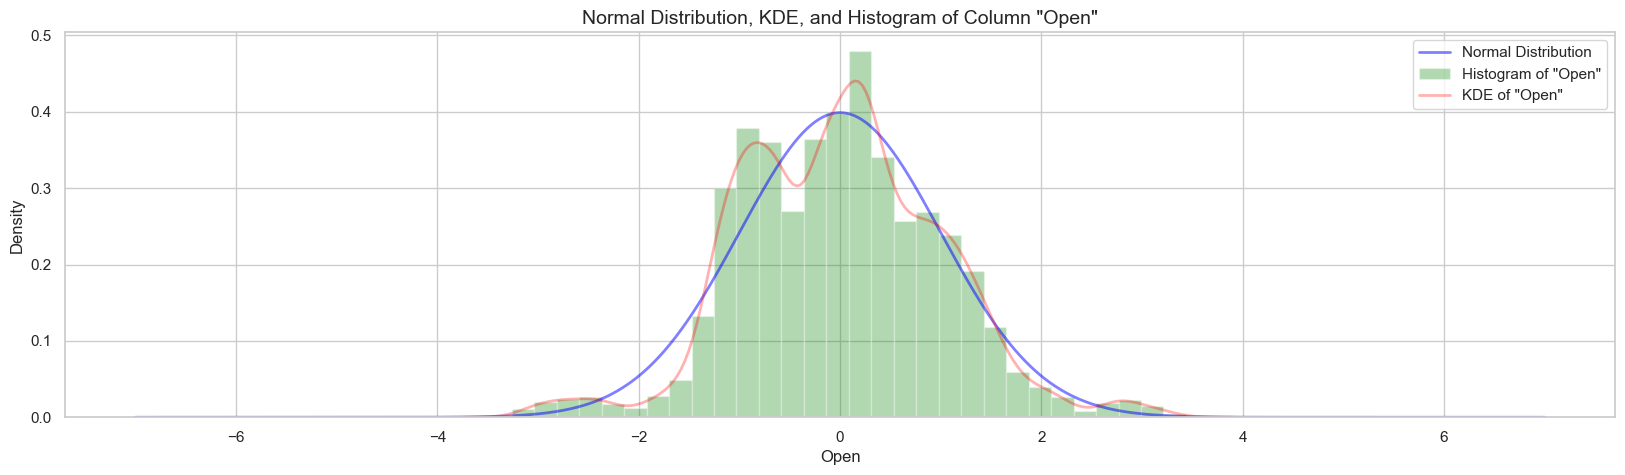

In [17]:
# Set the plot style
sns.set_theme(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 5))

# Extract 'Open' data from the entire DataFrame
open_data = df_standardized["Open"].dropna()

# Calculate the mean and standard deviation of 'Open' data
mu, std = norm.fit(open_data)

# Create a range of values for the normal distribution
x = np.linspace(mu - 7 * std, mu + 7 * std, 1000)

# Calculate the PDF of the normal distribution
p = norm.pdf(x, mu, std)

# Plot the normal distribution for the 'Open' column
ax.plot(x, p, linewidth=2, alpha=0.5, color="blue", label="Normal Distribution")

# Add the histogram of 'Open' prices in the background
ax.hist(
    open_data,
    bins=30,
    density=True,
    alpha=0.3,
    color="green",
    label='Histogram of "Open"',
)

# Add the KDE of 'Open' prices as a faint normal distribution
sns.kdeplot(
    open_data, ax=ax, color="red", linewidth=2, alpha=0.3, label='KDE of "Open"'
)

# Set the plot title and legend
ax.set_title('Normal Distribution, KDE, and Histogram of Column "Open"', fontsize=14)
ax.legend()

# Show the plot
plt.show()